In [84]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [85]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [4]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [5]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [7]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [8]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [10]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

In [11]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [12]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [0, 0, 0, 0, 0],
                            1: [1, 0, 0, 0, 0],
                            2: [0, 1, 0, 0, 0],
                            3: [0, 0, 1, 0, 0]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

In [13]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# calculate_rule_score(batch)

## Create multitype SeqGan

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [15]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False,
          return_sequences=False, 
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [16]:
# critic is a copy of D, except that stateful=True

def build_critic(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True, # stateful, critic makes prediction on a partial sequence
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True, # stateful, critic makes prediction on a partial sequence
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    critic_value = Dense(1, 
             activation='sigmoid',
             name='critic_final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=critic_value)
    return discriminator

In [17]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator


# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [67]:
def rollout_from_initial_mcc(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    all_token_logits = tf.zeros_like(init_et)
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
#     # LSTM-token
    G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    # LSTM-time
    G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.truncated_normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # non-differentiable sampling
        sampled_et_ind = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
        sampled_et = tf.one_hot(sampled_et_ind, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
        
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        token_logits = tf.reshape(token_logits, [batch_size, 1, EVENT_VOCAB_DIM]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)
        all_token_logits = tf.concat([all_token_logits, token_logits], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :], all_token_logits[:,1:,:]


def generate_sequences_mcc(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    all_token_logits = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts, batch_token_logits = rollout_from_initial_mcc(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
            all_token_logits = batch_token_logits
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)
            all_token_logits = tf.concat([all_token_logits, batch_token_logits], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]
    all_token_logits = all_token_logits[:N_gen, :, :]

    return all_type_seq, all_time_seq, all_token_logits

## Pre-Training using MLE

In [65]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [57]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [58]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [59]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
token ce loss:1.4297610685091509
time mae loss:0.8102964999059232
train loss:2.2400575684150743


1it [00:01,  1.07s/it]

Training Step: 2
token ce loss:1.3824813390791142
time mae loss:0.8078768942268217
train loss:2.190358233305936


2it [00:02,  1.02s/it]

Training Step: 3
token ce loss:1.3603935554606859
time mae loss:0.7968666094972093
train loss:2.1572601649578953


3it [00:03,  1.00s/it]

Training Step: 4
token ce loss:1.3638821646099162
time mae loss:0.7827206920984559
train loss:2.146602856708372


4it [00:04,  1.01it/s]

Training Step: 5
token ce loss:1.3668334285488115
time mae loss:0.7805461581412271
train loss:2.1473795866900387


5it [00:05,  1.00it/s]

Training Step: 6
token ce loss:1.3598033114333585
time mae loss:0.7898709780835271
train loss:2.1496742895168857


6it [00:06,  1.01it/s]

Training Step: 7
token ce loss:1.3501882059906665
time mae loss:0.7820348552699143
train loss:2.132223061260581


7it [00:06,  1.01it/s]

Training Step: 8
token ce loss:1.3492598949762507
time mae loss:0.7834722857788528
train loss:2.132732180755103


8it [00:07,  1.01it/s]

Training Step: 9
token ce loss:1.3408185913359618
time mae loss:0.7859998575001824
train loss:2.1268184488361443


9it [00:08,  1.02it/s]

Training Step: 10
token ce loss:1.332043169656852
time mae loss:0.7854343313245531
train loss:2.117477500981405


10it [00:09,  1.06it/s]

Training Step: 11
token ce loss:1.3294287553437822
time mae loss:0.7880910235409002
train loss:2.1175197788846827


11it [00:10,  1.10it/s]

Training Step: 12
token ce loss:1.3266973931450012
time mae loss:0.781516894648236
train loss:2.1082142877932375


12it [00:11,  1.12it/s]

Training Step: 13
token ce loss:1.323825366953003
time mae loss:0.7758475271329229
train loss:2.0996728940859257


13it [00:12,  1.08it/s]

Training Step: 14
token ce loss:1.3234860433244429
time mae loss:0.7930476244834652
train loss:2.116533667807908


14it [00:13,  1.05it/s]

Training Step: 15
token ce loss:1.326557020265003
time mae loss:0.782767228578124
train loss:2.109324248843127


15it [00:14,  1.04it/s]

Training Step: 16
token ce loss:1.322190460576782
time mae loss:0.7854038286550077
train loss:2.10759428923179


16it [00:15,  1.02it/s]

Training Step: 17
token ce loss:1.316508633055769
time mae loss:0.7700862948090426
train loss:2.0865949278648115


17it [00:16,  1.02it/s]

Training Step: 18
token ce loss:1.3147999075132282
time mae loss:0.7856230446311122
train loss:2.1004229521443403


18it [00:17,  1.01it/s]

Training Step: 19
token ce loss:1.3127208989719603
time mae loss:0.7826448322748295
train loss:2.09536573124679


19it [00:18,  1.01it/s]

Training Step: 20
token ce loss:1.309259125751405
time mae loss:0.7733634368106524
train loss:2.0826225625620576


20it [00:19,  1.00it/s]

Training Step: 21
token ce loss:1.313441986201901
time mae loss:0.7887055974878739
train loss:2.1021475836897747


21it [00:20,  1.00it/s]

Training Step: 22
token ce loss:1.302237970563268
time mae loss:0.7767801797895897
train loss:2.0790181503528578


22it [00:21,  1.01s/it]

Training Step: 23
token ce loss:1.3071395811698903
time mae loss:0.7819585244634333
train loss:2.0890981056333233


23it [00:22,  1.00s/it]

Training Step: 24
token ce loss:1.3049790889287345
time mae loss:0.7819231596700846
train loss:2.086902248598819


24it [00:23,  1.02it/s]

Training Step: 25
token ce loss:1.298887749320043
time mae loss:0.778625510859132
train loss:2.077513260179175


25it [00:24,  1.04it/s]

Training Step: 26
token ce loss:1.3033745586622008
time mae loss:0.7768005104174446
train loss:2.0801750690796452


26it [00:25,  1.03it/s]

Training Step: 27
token ce loss:1.2949149218295297
time mae loss:0.7795714611599985
train loss:2.0744863829895284


27it [00:26,  1.02it/s]

Training Step: 28
token ce loss:1.2928710836338688
time mae loss:0.7808646771536938
train loss:2.073735760787563


28it [00:27,  1.02it/s]

Training Step: 29
token ce loss:1.2896759658613863
time mae loss:0.7870204333932395
train loss:2.076696399254626


29it [00:28,  1.01it/s]

Training Step: 30
token ce loss:1.2964983332507212
time mae loss:0.7736234268158761
train loss:2.0701217600665975


30it [00:29,  1.02it/s]

Training Step: 31
token ce loss:1.29876293252765
time mae loss:0.7758471049203007
train loss:2.074610037447951


31it [00:30,  1.02it/s]

Training Step: 32
token ce loss:1.2978327258042446
time mae loss:0.7959846315616568
train loss:2.0938173573659014


32it [00:31,  1.02it/s]

Training Step: 33
token ce loss:1.2943247242568934
time mae loss:0.7827617848632659
train loss:2.0770865091201594


33it [00:32,  1.01it/s]

Training Step: 34
token ce loss:1.2911590848398042
time mae loss:0.7781059221282228
train loss:2.069265006968027


34it [00:33,  1.03s/it]

Training Step: 35
token ce loss:1.2858037204509352
time mae loss:0.7735953982735255
train loss:2.0593991187244605


35it [00:34,  1.02s/it]

Training Step: 36
token ce loss:1.2909523334775088
time mae loss:0.7707368926963586
train loss:2.0616892261738675


36it [00:35,  1.00s/it]

Training Step: 37
token ce loss:1.2887655689761346
time mae loss:0.7804171701901715
train loss:2.069182739166306


37it [00:36,  1.00it/s]

Training Step: 38
token ce loss:1.2933104244943865
time mae loss:0.7784248098448782
train loss:2.0717352343392648


38it [00:37,  1.05it/s]

Training Step: 39
token ce loss:1.2917742081366186
time mae loss:0.7795866502275766
train loss:2.071360858364195


39it [00:38,  1.08it/s]

Training Step: 40
token ce loss:1.2860569400032151
time mae loss:0.7834438162558871
train loss:2.069500756259102


40it [00:38,  1.12it/s]

Training Step: 41
token ce loss:1.2894921702350717
time mae loss:0.7665345972729094
train loss:2.056026767507981


41it [00:39,  1.13it/s]

Training Step: 42
token ce loss:1.2821232409246115
time mae loss:0.7681254306858615
train loss:2.050248671610473


42it [00:40,  1.08it/s]

Training Step: 43
token ce loss:1.285756990443013
time mae loss:0.7682815204866507
train loss:2.0540385109296637


43it [00:41,  1.06it/s]

Training Step: 44
token ce loss:1.2825614090918493
time mae loss:0.7725570103520516
train loss:2.055118419443901


44it [00:42,  1.04it/s]

Training Step: 45
token ce loss:1.2839594062357775
time mae loss:0.7966468888637873
train loss:2.0806062950995647


45it [00:43,  1.03it/s]

Training Step: 46
token ce loss:1.276259760085819
time mae loss:0.7877001128950027
train loss:2.0639598729808215


46it [00:44,  1.03it/s]


In [60]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [61]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_10 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [43]:
N_fake_D = N_real_D = N_total_G 

In [68]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs, _ = generate_sequences_mcc(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [69]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [70]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [71]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [72]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
total discriminator loss:0.703598470116161


1it [00:00,  1.64it/s]

Training Step: 2
total discriminator loss:0.6830114051045489


2it [00:01,  1.76it/s]

Training Step: 3
total discriminator loss:0.6670575900989302


3it [00:01,  1.81it/s]

Training Step: 4
total discriminator loss:0.6366159271587752


4it [00:02,  1.83it/s]

Training Step: 5
total discriminator loss:0.6216779262451122


5it [00:02,  1.83it/s]

Training Step: 6
total discriminator loss:0.5955789889881881


6it [00:03,  1.82it/s]

Training Step: 7
total discriminator loss:0.5805332934225175


7it [00:03,  1.82it/s]

Training Step: 8
total discriminator loss:0.5703157834632441


8it [00:04,  1.83it/s]

Training Step: 9
total discriminator loss:0.5282789871662232


9it [00:04,  1.83it/s]

Training Step: 10
total discriminator loss:0.5312463369799714


10it [00:05,  1.83it/s]

Training Step: 11
total discriminator loss:0.49730150914915033


11it [00:06,  1.82it/s]

Training Step: 12
total discriminator loss:0.45445829907848007


12it [00:06,  1.83it/s]

Training Step: 13
total discriminator loss:0.39019445966044697


13it [00:07,  1.84it/s]

Training Step: 14
total discriminator loss:0.41271928418021514


14it [00:07,  1.82it/s]

Training Step: 15
total discriminator loss:0.3682390786997698


15it [00:08,  1.81it/s]

Training Step: 16
total discriminator loss:0.37250702455100526


16it [00:08,  1.95it/s]

Training Step: 17
total discriminator loss:0.32443891637038


17it [00:09,  2.05it/s]

Training Step: 18
total discriminator loss:0.3138747709381744


18it [00:09,  2.12it/s]

Training Step: 19
total discriminator loss:0.27675061746049334


19it [00:09,  2.17it/s]

Training Step: 20
total discriminator loss:0.2192536412899822


20it [00:10,  2.21it/s]

Training Step: 21
total discriminator loss:0.2460170627621315


21it [00:10,  2.24it/s]

Training Step: 22
total discriminator loss:0.2159178246373006


22it [00:11,  2.29it/s]

Training Step: 23


23it [00:11,  2.31it/s]

total discriminator loss:0.18521321730368095
Training Step: 24
total discriminator loss:0.1529252078110578


24it [00:12,  2.17it/s]

Training Step: 25
total discriminator loss:0.16463541732986778


25it [00:12,  2.05it/s]

Training Step: 26
total discriminator loss:0.09298411488760631


26it [00:13,  1.95it/s]

Training Step: 27
total discriminator loss:0.16263635861386963


27it [00:13,  1.92it/s]

Training Step: 28
total discriminator loss:0.07884539138212875


28it [00:14,  1.90it/s]

Training Step: 29
total discriminator loss:0.11109962442800901


29it [00:14,  1.86it/s]

Training Step: 30
total discriminator loss:0.09452716111499987


30it [00:15,  1.83it/s]

Training Step: 31
total discriminator loss:0.033331530965415815


31it [00:16,  1.93it/s]


In [73]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [74]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_12 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Monte-Carlo with Critic  Traning

In [93]:
def train_generator_mcc(generator, discriminator, critic, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    # clear critic states for a new batch
    critic.reset_states()
    
    with tf.GradientTape(persistent=True) as tape:     
                        
        gen_step_loss = []
        critic_step_loss = []

        G_sample_et, G_sample_ts, G_token_logits = generate_sequences_mcc(batch_size, generator, batch_size, T)        
        
        true_return = discriminator([G_sample_et, G_sample_ts])
        
        # Monte-Carlo with Critic
        for i in range(T):  
            curr_state_et = G_sample_et[:, -1:, :]
            curr_state_ts = G_sample_ts[:, -1:, :]
            curr_token_logits = G_token_logits[:, -1:, :]
        
            q_value = critic([curr_state_et, curr_state_ts])
            advantage = true_return - q_value
        
            # averge loss over batch at each rollout step: -E[log_prob * Q]
            policy_gradient_loss = -tf.reduce_mean(tf.math.log(tf.nn.softmax(curr_token_logits)) * advantage)
            gen_step_loss.append(policy_gradient_loss)
            
            critic_mse_loss = tf.reduce_mean(tf.keras.losses.MSE(true_return, q_value))
            critic_step_loss.append(critic_mse_loss)
            
        generator_loss = tf.reduce_mean(gen_step_loss)
        critic_loss = tf.reduce_mean(critic_step_loss)
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('critic loss:{}'.format(critic_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    # update critic
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return generator_loss, critic_loss


def train_discriminator_mcc(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))
    fake_labels = tf.zeros((batch_size//2, 1))
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [94]:
def track_training(step, G, save_path=None, verbose=True, plot=True):
    _gen_seqs_et, _gen_seqs_ts, _ = generate_sequences_mcc(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path:     
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)

        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

In [98]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

critic = build_critic(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

critic.build(input_shape=((BATCH_SIZE, T, 1)))
critic.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_28 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [99]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
critic_loss_history = []
average_true_return_history = []
mad_history = []
fid_history = []
rule_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
model_save_path = os.path.join(model_save_dir, now_str)
print(model_save_path)
print(_TOTAL_STEPS)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40
1562


0it [00:00, ?it/s]

Training Step: 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
event_types: [1, 0, 2, 0, 3, 2, 3, 3, 0, 2, 2, 1, 2, 0, 1, 2, 3, 0, 2, 2]
mad_score: 0.4315125
fid_score: 9481.020606434931
rule_score: 0.475


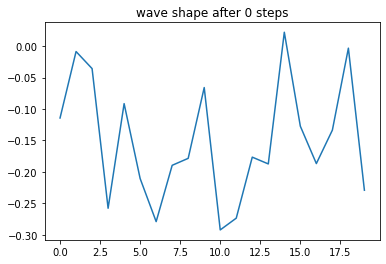

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/D_0/model_weights.tf
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set th

1it [00:12, 12.31s/it]

total discriminator loss:0.46529876630464984
average true return:0.5452324771155109
-----------------------
Training Step: 1
generator loss:-0.7595786349489344
critic loss:0.25084452388530815
-----------------------
total discriminator loss:1.2176856955314939
average true return:0.19484974091241658
-----------------------


2it [00:15,  7.00s/it]

Training Step: 2
generator loss:-0.6805482427681384
critic loss:0.18943528174434512
-----------------------


3it [00:19,  5.37s/it]

total discriminator loss:0.5369816858662858
average true return:0.436901378897223
-----------------------
Training Step: 3
generator loss:-0.31344079850409434
critic loss:0.08125033005520357
-----------------------


4it [00:22,  4.52s/it]

total discriminator loss:0.44023194513963393
average true return:0.5747128174907181
-----------------------
Training Step: 4
generator loss:0.3560983244369912
critic loss:0.12634120854963865
-----------------------


5it [00:25,  4.04s/it]

total discriminator loss:0.6872947877240523
average true return:0.7298441618991163
-----------------------
Training Step: 5
event_types: [2, 2, 0, 2, 2, 3, 3, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2]
mad_score: 0.31865
fid_score: 24538.892743339988
rule_score: 0.00075


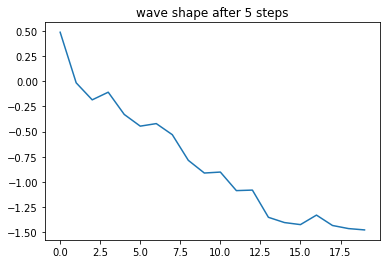

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/D_5/model_weights.tf
generator loss:0.019119570395921964
critic loss:0.04779427112481026
-----------------------


6it [00:37,  6.77s/it]

total discriminator loss:2.9832029444390273
average true return:0.6121956548198104
-----------------------
Training Step: 6
generator loss:0.23627847999229606
critic loss:0.057143449310299486
-----------------------


7it [00:40,  5.61s/it]

total discriminator loss:0.4969317291273889
average true return:0.6841017524595656
-----------------------
Training Step: 7
generator loss:0.25155592492413353
critic loss:0.0458741676611691
-----------------------


8it [00:43,  4.84s/it]

total discriminator loss:0.48121098778421845
average true return:0.6703732441337573
-----------------------
Training Step: 8
generator loss:0.07767002259613934
critic loss:0.022594713407002115
-----------------------


9it [00:47,  4.33s/it]

total discriminator loss:0.3842220367743528
average true return:0.6181045590440412
-----------------------
Training Step: 9
generator loss:-0.1192232418117349
critic loss:0.01210638094340945
-----------------------


10it [00:50,  3.98s/it]

total discriminator loss:0.3665435962749114
average true return:0.5828290675299651
-----------------------
Training Step: 10
event_types: [1, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1]
mad_score: 0.29065
fid_score: 110534.2256213154
rule_score: 0.0


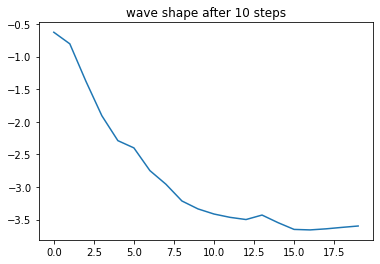

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/D_10/model_weights.tf
generator loss:-0.2401976548086549
critic loss:0.01899397171980165
-----------------------


11it [01:02,  6.50s/it]

total discriminator loss:0.3186980765590589
average true return:0.5553024936012096
-----------------------
Training Step: 11
generator loss:-0.2874356245538361
critic loss:0.022228341272948444
-----------------------


12it [01:05,  5.53s/it]

total discriminator loss:0.37810274610453143
average true return:0.5407579499273759
-----------------------
Training Step: 12
generator loss:-0.3025260495751162
critic loss:0.02056509705198052
-----------------------


13it [01:09,  4.85s/it]

total discriminator loss:0.35109272363609023
average true return:0.5303742744125031
-----------------------
Training Step: 13
generator loss:-0.3002509704936927
critic loss:0.016251474824636992
-----------------------


14it [01:12,  4.38s/it]

total discriminator loss:0.3259428939715375
average true return:0.5193252725163137
-----------------------
Training Step: 14
generator loss:-0.27584907292150335
critic loss:0.011614871860026323
-----------------------


15it [01:15,  4.06s/it]

total discriminator loss:2.407368059733326
average true return:0.5080488658937155
-----------------------
Training Step: 15
event_types: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.1260875
fid_score: 253726.73643481382
rule_score: 0.0


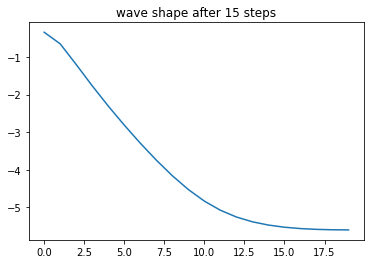

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/D_15/model_weights.tf
generator loss:-0.1439720978526736
critic loss:0.006268545816825698
-----------------------


16it [01:28,  6.73s/it]

total discriminator loss:0.31518667382388615
average true return:0.5107182621961435
-----------------------
Training Step: 16
generator loss:0.025348682151695993
critic loss:0.0052831781406195094
-----------------------


17it [01:32,  5.74s/it]

total discriminator loss:0.33145616183255633
average true return:0.49647042112595985
-----------------------
Training Step: 17
generator loss:0.15388161081088403
critic loss:0.006339670177959458
-----------------------


18it [01:35,  5.05s/it]

total discriminator loss:0.32099511926532237
average true return:0.48870079765200336
-----------------------
Training Step: 18
generator loss:0.207522021370192
critic loss:0.007242644054563356
-----------------------


19it [01:39,  4.64s/it]

total discriminator loss:0.33418972338444464
average true return:0.48208430253248247
-----------------------
Training Step: 19
generator loss:0.20690103390613773
critic loss:0.007667602790203519
-----------------------


20it [01:42,  4.29s/it]

total discriminator loss:0.3206630864468787
average true return:0.47724864276731077
-----------------------
Training Step: 20
event_types: [2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.0974375
fid_score: 127815.4111585349
rule_score: 0.0


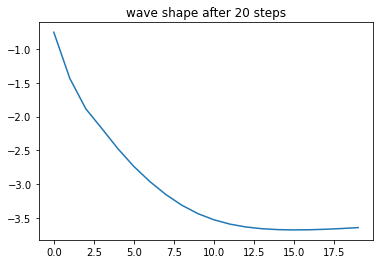

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/2021-03-30-10-26-40/D_20/model_weights.tf
generator loss:0.16928992012499852
critic loss:0.007729484941959003
-----------------------


21it [01:55,  6.86s/it]

total discriminator loss:0.32226539541710253
average true return:0.47385667726912284
-----------------------
Training Step: 21
generator loss:0.13302902663890037
critic loss:0.007943159562627262
-----------------------


21it [01:57,  5.58s/it]


KeyboardInterrupt: 

In [100]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, model_save_path, verbose=True, plot=True)
        mad_history.append(_mad_score)
        fid_history.append(_fid_score)
        rule_history.append(_rule_score)
        
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss, critic_loss = train_generator_mcc(G, D, critic, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_mcc(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
                
    step += 1

In [ ]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(10, G0, BATCH_SIZE, T)
print(tf.argmax(seqs_random_et, axis=2))

ind = 1
x = np.arange(seqs_random_ts[ind,:,:].shape[0])
y = seqs_random_ts[ind,:,:]

plt.plot(x, y)

In [ ]:
G1 = pretrained_generator
seqs_pretrained_et, seqs_pretrained_ts = generate_sequences_gumbel(10, G1, BATCH_SIZE, T)
print(tf.argmax(seqs_pretrained_et, axis=2))

ind = 1
x = np.arange(seqs_pretrained_ts[ind,:,:].shape[0])
y = seqs_pretrained_ts[ind,:,:]

plt.plot(x, y)

In [ ]:
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(10, G2, BATCH_SIZE, T)

print(tf.argmax(seqs_trained_et, axis=2))

ind = 3
x = np.arange(seqs_trained_ts[ind,:,:].shape[0])
y = seqs_trained_ts[ind,:,:]

plt.plot(x, y)

In [ ]:
raw_seqs_trained_et_100, raw_seqs_trained_ts_100 = generate_sequences_gumbel(400, G2, BATCH_SIZE, T)

In [ ]:
 tf.argmax(raw_seqs_trained_et_100, axis=2)

In [ ]:
apply_mean_std(raw_seqs_trained_ts_100, *get_mean_std(raw_pos_timestamp_seqs))

## Save trained G and D weights

In [ ]:
if not os.path.exists(model_save_dir + '/G_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/G_run_syn_v11_200')

G_save_path = model_save_dir + '/G_run_syn_v11_200/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/D_run_syn_v11_200')

D_save_path = model_save_dir + '/D_run_syn_v11_200/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Generate Synthesized data

In [ ]:
G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/G_run_syn_v11_200/model.tf'

In [ ]:
G_200 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G_200.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

In [ ]:
G_100 = G2
raw_seqs_trained_et_100, raw_seqs_trained_ts_100 = generate_sequences_gumbel(400000, G_100, BATCH_SIZE, T)

In [ ]:
seqs_save_et_100 = tf.argmax(raw_seqs_trained_et_100[:400000, :, :], axis=2)
seqs_save_ts_100 = apply_mean_std(raw_seqs_trained_ts_100[:400000, :, :], *get_mean_std(raw_pos_timestamp_seqs))

In [ ]:
import pickle

pos_seqs_filename_et = 'syn_positive_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_positive_time_sequences.pickle'

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_et), 'wb') as f:
    pickle.dump(seqs_save_et_100, f)
    
with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(seqs_save_ts_100, f)

In [ ]:
seqs_save_et_100[:10]

In [ ]:
seqs_save_ts_100[:10]